# Use this to access the Venv
source ../PALM-Distributed-Training/tensor_env/bin/activate

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras import layers, models
import tensorflow as tfa
from tensorflow.keras.optimizers import RMSprop, Adam
import keras_tuner as kt

2024-07-10 23:15:59.003210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 23:15:59.003304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 23:15:59.027373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 23:15:59.078832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 23:15:59.975898: W tensorflow/compiler/tf2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4'
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


2024-07-10 23:16:01.621866: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 23:16:01.622550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 23:16:01.623105: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [23]:
labels_df = pd.read_csv('/home/nate/distributed_training/retinopathy_data/aptos-2015-training.csv')
image_paths = labels_df['image'].apply(lambda x: os.path.join('/home/nate/distributed_training/retinopathy_data/train_resized', x + '.jpg')).tolist()
labels = labels_df['level'].tolist()

### Class Weight Adjustment

In [24]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# labels = np.array(labels)  # Assuming 'labels' is your list/array of labels

# # Find unique classes and their distributions
# unique_classes = np.unique(labels)
# class_distribution = [sum(labels == i) for i in unique_classes]

# # Calculate class weights
# weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=labels)
# class_weights = {class_label: weight for class_label, weight in zip(unique_classes, weights)}

# print("Class weights: ", class_weights)


In [25]:
# # Original class weights
# class_weights = {0: 0.27218907400232467, 1: 2.875644699140401, 2: 1.3275132275132275, 3: 8.047193585337915, 4: 9.922598870056497}

# # Determine a scaling factor
# scaling_factor = 0.5  # Example scaling factor, adjust based on your needs

# # Scale the class weights
# moderate_class_weights = {k: v ** scaling_factor for k, v in class_weights.items()}

# # Assuming class_datasets are ordered by class labels
# class_labels = sorted(moderate_class_weights.keys())
# moderate_class_weights_list = [moderate_class_weights[label] for label in class_labels]

# print("Moderate class weights: ", moderate_class_weights)

In [26]:
# # Sum of original class weights
# weights_sum = sum(class_weights.values())

# # Number of classes
# num_classes = len(class_weights)

# # Normalize class weights to sum up to num_classes
# normalized_class_weights = {k: (v / weights_sum) * num_classes for k, v in class_weights.items()}

# # Assuming class_datasets are ordered by class labels
# class_labels = sorted(moderate_class_weights.keys())
# normalized_class_weights_list = [normalized_class_weights[label] for label in class_labels]

# print("Normalized class weights: ", normalized_class_weights)

In [27]:
from sklearn.model_selection import train_test_split

# Assuming image_paths and labels are your full dataset
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

In [28]:
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    # If using ResNet50V2's preprocess_input, remove the manual rescaling above
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image, label

In [29]:
# Your moderate class weights
class_weights = {0: 0.27218907400232467, 1: 2.875644699140401, 2: 1.3275132275132275, 3: 8.047193585337915, 4: 9.922598870056497}
scaling_factor = 0.5  # Adjust based on your needs
moderate_class_weights = {k: v ** scaling_factor for k, v in class_weights.items()}

# Calculate the maximum weight to determine the oversampling ratio
max_weight = max(moderate_class_weights.values())

# Calculate oversampling ratios
oversampling_ratios = {k: max_weight / v for k, v in moderate_class_weights.items()}


In [30]:
import random
# Placeholder for the new oversampled dataset
oversampled_image_paths = []
oversampled_labels = []

# Perform oversampling
for label, path in zip(train_labels, train_image_paths):
    num_samples = int(round(oversampling_ratios[label]))  # Determine the number of times to replicate each sample
    oversampled_image_paths.extend([path] * num_samples)
    oversampled_labels.extend([label] * num_samples)

# Shuffle the oversampled dataset to ensure mixed classes
oversampled_dataset = list(zip(oversampled_image_paths, oversampled_labels))
random.shuffle(oversampled_dataset)  # Ensure you've imported random

# Unzip the shuffled dataset back into image paths and labels
oversampled_image_paths, oversampled_labels = zip(*oversampled_dataset)


In [31]:
import tensorflow as tf
import random

def create_dataset(image_paths, labels, batch_size, is_training=True):
    # Convert lists to TensorFlow tensors
    image_paths = tf.constant(image_paths)
    labels = tf.constant(labels)
    
    # Create a TensorFlow dataset from the tensors
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Map the preprocessing function with parallel processing
    dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        # Shuffle the dataset using the buffer size and enable reshuffling each iteration
        dataset = dataset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)
    
    # Batch the dataset and prefetch to improve performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Assuming BUFFER_SIZE, BATCH_SIZE, and mirrored_strategy are defined
BUFFER_SIZE = 10000
BATCH_SIZE_PER_REPLICA = 500
mirrored_strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync

# Use the oversampled dataset for training
train_ds = create_dataset(list(oversampled_image_paths), list(oversampled_labels), BATCH_SIZE, is_training=True)
val_ds = create_dataset(list(val_image_paths), list(val_labels), BATCH_SIZE, is_training=False)  # Validation dataset doesn't necessarily need oversampling


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')


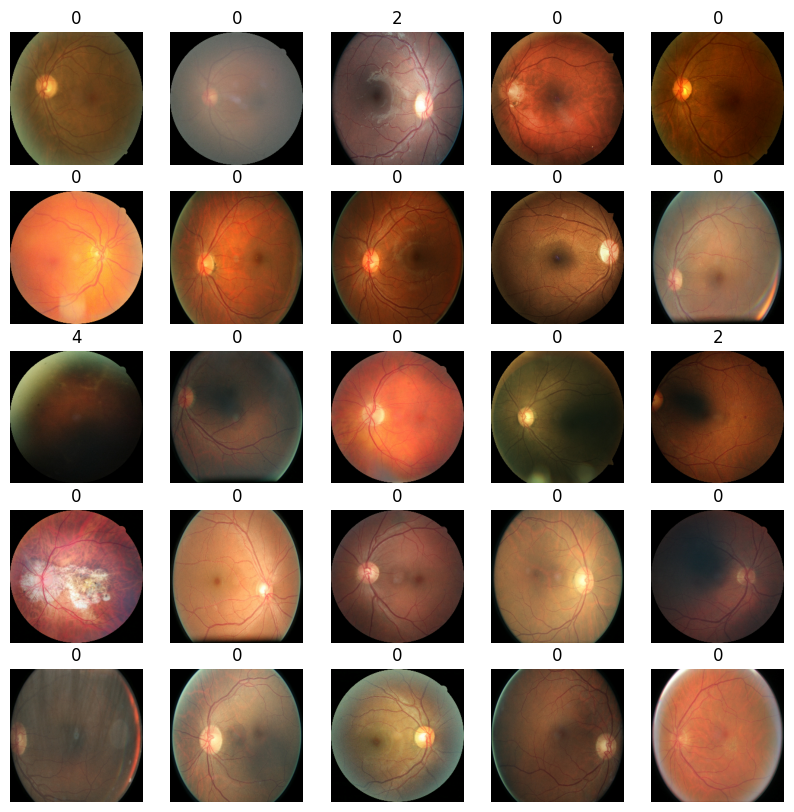

In [32]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(min(len(image_batch), 25)):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n] / 2 + 0.5)  # Rescale back to [0,1] if preprocessing included normalization
        plt.title(label_batch[n].numpy())
        plt.axis('off')

# Taking one batch from the training dataset
for image_batch, label_batch in train_ds.take(1):
    show_batch(image_batch.numpy(), label_batch)
# Note: This visualization step assumes that your preprocessing function normalizes the images in a way that can be reversed for visualization.


In [33]:
# import keras_tuner as kt
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.models import Model

# mirrored_strategy = tf.distribute.MirroredStrategy()

# with mirrored_strategy.scope():
#     def build_model(hp):
#         model = keras.Sequential()
        
#         # Data Augmentation with tunable parameters
#         model.add(layers.experimental.preprocessing.RandomFlip(
#             mode=hp.Choice('flip_mode', values=['vertical', 'horizontal_and_vertical']),
#             input_shape=(224, 224, 3)))
#         model.add(layers.experimental.preprocessing.RandomRotation(
#             factor=hp.Float('rotation_factor', min_value=0.0, max_value=0.1))),
#         model.add(layers.experimental.preprocessing.RandomZoom(
#             height_factor=hp.Float('height_factor', min_value=-0.50, max_value=0.05),
#             width_factor=hp.Float('width_factor', min_value=-0.50, max_value=0.05)))
#         model.add(layers.experimental.preprocessing.RandomContrast(
#             factor=hp.Float('contrast_factor', min_value=0.005, max_value=0.3)))
    
#         # Base model without top layers, not trainable
#         base_model = keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        
#         # Create a new model that excludes the last 5 layers
#         # This is a simplistic approach and might need adjustment.
#         new_output = base_model.layers[-6].output
#         base_model_truncated = Model(inputs=base_model.input, outputs=new_output)
#         base_model_truncated.trainable = False
        
#         model.add(base_model_truncated)
        
       
#         # Custom layers atop the pre-trained model
#         model.add(layers.GlobalAveragePooling2D())
#         model.add(layers.Dense(units=hp.Int('units_0', min_value=64, max_value=1024, step=32), activation='relu')),
#         model.add(layers.Dropout(rate=hp.Float('dropout_rate_0', min_value=0.0, max_value=0.5, step=0.1))),
#         model.add(layers.Dense(units=hp.Int('units_1', min_value=64, max_value=1024, step=32), activation='relu')),
#         model.add(layers.Dropout(rate=hp.Float('dropout_rate_1', min_value=0.0, max_value=0.5, step=0.1))),
#         model.add(layers.Dense(units=hp.Int('units_2', min_value=64, max_value=1024, step=32), activation='relu')),
#         model.add(layers.Dropout(rate=hp.Float('dropout_rate_2', min_value=0.0, max_value=0.5, step=0.1))),
#         model.add(layers.Dense(units=hp.Int('units_3', min_value=64, max_value=1024, step=32), activation='relu')),
#         model.add(layers.Dropout(rate=hp.Float('dropout_rate_3', min_value=0.0, max_value=0.5, step=0.1))),
#         model.add(layers.Dense(units=hp.Int('units_4', min_value=64, max_value=1024, step=32), activation='relu')),
#         model.add(layers.Dropout(rate=hp.Float('dropout_rate_4', min_value=0.0, max_value=0.5, step=0.1))),
#         model.add(layers.Dense(5, activation='softmax'))  # Adjust the number of units based on your number of classes
        
#         # Custom Optimizer Choices
#         optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'adamw'])

#         if optimizer_choice == 'adam':
#             optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4]))
#         elif optimizer_choice == 'sgd':
#             optimizer = keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4]), momentum=0.9)
#         elif optimizer_choice == 'adamw':
#             optimizer = tfa.optimizers.AdamW(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4]), weight_decay=1e-4)
        
#         # Compile the model
#         model.compile(
#             optimizer=optimizer,
#             loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])
        
#         return model

In [34]:
# # Initialize the tuner
# tuner = kt.Hyperband(build_model,
#                      objective='val_accuracy',
#                      distribution_strategy=mirrored_strategy,
#                      max_epochs=130,
#                      factor=3,
#                      directory='5_mr_units_Distributed_Omicron_Distributed',
#                      project_name='5_mr_units_fine_tuning')

In [35]:
# # Start the search
# tuner.search(train_ds, epochs=130, validation_data=val_ds)

In [36]:
# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Build the model with the best hyperparameters
# best_model = tuner.hypermodel.build(best_hps)


### Show best hyperparameters

In [37]:
# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Print out the best hyperparameters
# print("Best hyperparameters found by the 5_mr_units_tuner:\n")
# for hp in best_hps.values:
#     print(f"{hp}: {best_hps.get(hp)}")

In [38]:
_5_Best_model_params =  """
Trial 254 Complete [01h 47m 15s]
val_accuracy: 0.7346996665000916

Best val_accuracy So Far: 0.7389695644378662
Total elapsed time: 2d 04h 02m 04s

Best hyperparameters found by the 5_mr_units_tuner:

flip_mode: horizontal_and_vertical
rotation_factor: 0.03173526445886683
height_factor: -0.05392633611981862
width_factor: -0.0829257246869532
contrast_factor: 0.055162989092493085
units_0: 928
dropout_rate_0: 0.0
units_1: 96
dropout_rate_1: 0.30000000000000004
units_2: 288
dropout_rate_2: 0.1
units_3: 480
dropout_rate_3: 0.1
units_4: 640
dropout_rate_4: 0.30000000000000004
optimizer: adamw
learning_rate: 0.0001
tuner/epochs: 130
tuner/initial_epoch: 44
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
"""

## Only using GPU 0 and 1 for training to free up space for other tasks

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model



with mirrored_strategy.scope():
    def build_best_model():
        model = keras.Sequential()
        
        # Data Augmentation with the best parameters
        model.add(layers.experimental.preprocessing.RandomFlip(
            mode='horizontal_and_vertical',
            input_shape=(224, 224, 3)))
        model.add(layers.experimental.preprocessing.RandomRotation(factor=0.03173526445886683))
        model.add(layers.experimental.preprocessing.RandomZoom(
            height_factor=-0.05392633611981862,
            width_factor=-0.0829257246869532))
        model.add(layers.experimental.preprocessing.RandomContrast(factor=0.055162989092493085))
        
        # Base model without top layers, not trainable
        base_model = keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        
        # Truncate the base model's output to exclude the last 5 layers
        new_output = base_model.layers[-11].output
        base_model_truncated = Model(inputs=base_model.input, outputs=new_output)
        base_model_truncated.trainable = False
        
        model.add(base_model_truncated)
        
        # Custom layers atop the pre-trained model with the best parameters
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dense(units=928, activation='relu'))
        model.add(layers.Dropout(rate=0.0))
        model.add(layers.Dense(units=96, activation='relu'))
        model.add(layers.Dropout(rate=0.3))
        model.add(layers.Dense(units=288, activation='relu'))
        model.add(layers.Dropout(rate=0.1))
        model.add(layers.Dense(units=480, activation='relu'))
        model.add(layers.Dropout(rate=0.1))
        model.add(layers.Dense(units=640, activation='relu'))
        model.add(layers.Dropout(rate=0.3))
        model.add(layers.Dense(5, activation='softmax'))  # Assuming 5 classes for Diabetic Retinopathy
        
        # Optimizer with the best parameters
        optimizer = keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-4)
        
        # Compile the model with the specified loss function and metrics
        model.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
        
        return model

    # Build the model with the best hyperparameters
    best_model = build_best_model()


In [40]:
# Train the best model
history = best_model.fit(
    train_ds,
    epochs=50,  # Adjust based on your requirements and resources
    validation_data=val_ds,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)]
)

Epoch 1/50
INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 5, group_size = 5, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 12 all_reduces, num_devices = 5, group_size = 5, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-07-10 23:25:12.626826: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-10 23:25:12.665018: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-10 23:25:12.711985: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-10 23:25:12.764758: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-10 23:25:12.824077: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-10 23:25:20.722583: I external/local_xla/xla/service/service.cc:168] XLA service 0x63da2ddb5f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-10 23:25:20.722626: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-10 23:25:20.722658: I external/local_xla/xla/service/service.

57/57 [==============================] - 90s 1s/step - loss: 0.8348 - accuracy: 0.8385 - val_loss: 0.9654 - val_accuracy: 0.7347
Epoch 2/50
57/57 [==============================] - 47s 781ms/step - loss: 0.4909 - accuracy: 0.8739 - val_loss: 0.9328 - val_accuracy: 0.7347
Epoch 3/50
57/57 [==============================] - 49s 821ms/step - loss: 0.4877 - accuracy: 0.8739 - val_loss: 0.9107 - val_accuracy: 0.7347
Epoch 4/50
57/57 [==============================] - 47s 794ms/step - loss: 0.4855 - accuracy: 0.8739 - val_loss: 0.9017 - val_accuracy: 0.7347
Epoch 5/50
57/57 [==============================] - 49s 816ms/step - loss: 0.4848 - accuracy: 0.8739 - val_loss: 0.8905 - val_accuracy: 0.7347
Epoch 6/50
57/57 [==============================] - 47s 783ms/step - loss: 0.4833 - accuracy: 0.8739 - val_loss: 0.8826 - val_accuracy: 0.7347
Epoch 7/50
57/57 [==============================] - 49s 827ms/step - loss: 0.4826 - accuracy: 0.8739 - val_loss: 0.8796 - val_accuracy: 0.7347
Epoch 8/50
57

In [46]:


# from datetime import datetime

# model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')

from datetime import datetime

# Get the current date and time formatted as a string
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Construct the file path with the timestamp for saving the model
model_filename = f'/home/nate/distributed_training/Keras-Tuner-DR-Distributed-Training/Saved_models/_6_diabetic_retinopathy_model{timestamp}.keras'

best_model.save(model_filename)



<Axes: >

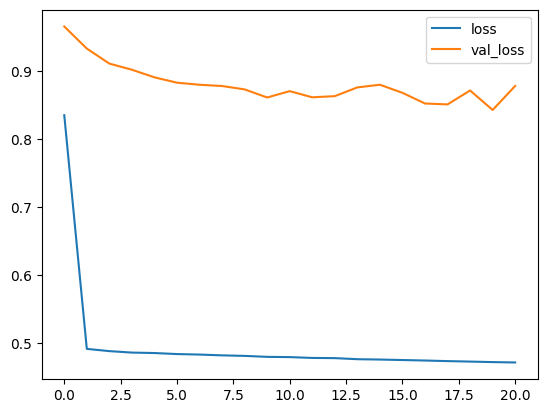

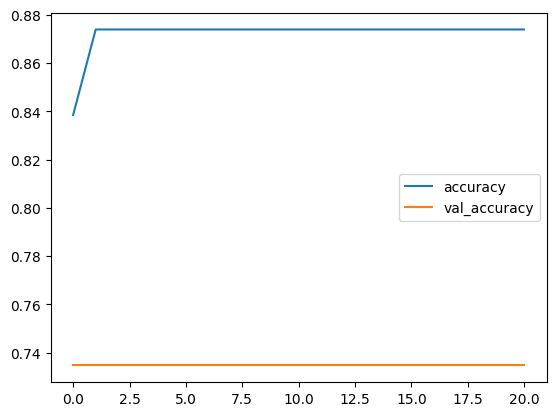

In [45]:
# print out the training history
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()